In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import cartopy.feature as cfeature
import matplotlib.path as mpath

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Some functions I wrote

def init_orthomap(nrow,ncol,bboxplot,centlon=-40,centlat=35,precision=40,
                  dx=10,dy=5,
                  frame_lw=2,frame_col="k",
                  figsize=(8,4.5),constrained_layout=True,ax=None):
    # Intiailize Ortograpphic map over North Atlantic.
    # Based on : https://stackoverflow.com/questions/74124975/cartopy-fancy-box
    # The default lat/lon projection
    noProj = ccrs.PlateCarree(central_longitude=0)
    
    # Set Orthographic Projection
    myProj = ccrs.Orthographic(central_longitude=centlon, central_latitude=centlat)
    myProj._threshold = myProj._threshold/precision  #for higher precision plot
    
    # Initialize Figure
    fig,axs = plt.subplots(nrow,ncol,figsize=figsize,subplot_kw={'projection': myProj},
                          constrained_layout=constrained_layout)
    
    # Get Line Coordinates
    xp,yp  = get_box_coords(bboxplot,dx=dx,dy=dy)
    
    # Draw the line
    if nrow ==1 and ncol ==1:
        #print("Nd Axis")
        axs = [axs,]
        ndaxis=False
    else:
        orishape = axs.shape
        axs      = axs.flatten()
        ndaxis   = True
    for ax in axs:
        [ax_hdl] = ax.plot(xp,yp,
            color=frame_col, linewidth=frame_lw,
            transform=noProj)
        
        # Make a polygon and crop
        tx_path                = ax_hdl._get_transformed_path()
        path_in_data_coords, _ = tx_path.get_transformed_path_and_affine()
        polygon1s              = mpath.Path( path_in_data_coords.vertices)
        ax.set_boundary(polygon1s) # masks-out unwanted part of the plot
        
    if ndaxis is False:
        axs = axs[0] # Return just the axis
    else:
        axs = axs.reshape(orishape)
    mapdict={
        'noProj'     : noProj,
        'myProj'     : myProj,
        'line_coords': (xp,yp),
        'polygon'    : polygon1s,
        }
    return fig,axs,mapdict


def get_box_coords(bbox,dx=None,dy=None):
    # Get coordinates of box for plotting an ortho map/polygon
    # Given [Westbound EastBound Southbound Northbound]
    # Returns xcoords and ycoords of path drawn from:
    # Lower Left, counterclockwise around and back.
    
    if dx is None:
        dx = np.linspace(bbox[0],bbox[1],5)
        dx = dx[1] - dx[0]
    if dy is None:
        dy = np.linspace(bbox[2],bbox[3],5)
        dy = dy[1] - dy[0]
    
    # Lower Edge (Bot. Left --> Bot. Right)
    lower_x = np.arange(bbox[0],bbox[1]+dx,dx) # x-coord
    nx = len(lower_x) 
    lower_y = [bbox[2],]*nx # y-coord
    
    # Right Edge (Bot. Right ^^^ Top Right)
    right_y = np.arange(bbox[2],bbox[3]+dy,dy)
    ny = len(right_y)
    right_x = [bbox[1],]*ny
    
    # Upper Edge (Top Left <-- Top Right)
    upper_x = np.flip(lower_x)
    upper_y = [bbox[3],]*nx
    
    # Left Edge (Bot. Left vvv Top Left)
    left_y  = np.flip(right_y)
    left_x  = [bbox[0],]*ny
    
    x_coords = np.hstack([lower_x,right_x,upper_x,left_x])
    y_coords = np.hstack([lower_y,right_y,upper_y,left_y])
    
    return x_coords,y_coords


def add_coast_grid(ax,bbox=[-180,180,-90,90],proj=None,blabels=[1,0,0,1],ignore_error=False,
                   fill_color=None,line_color='k',grid_color='gray',c_zorder=1,
                   fix_lon=False,fix_lat=False,fontsize=12):
    """
    Add Coastlines, grid, and set extent for geoaxes
    
    Parameters
    ----------
    ax : matplotlib geoaxes
        Axes to plot on 
    bbox : [LonW,LonE,LatS,LatN], optional
        Bounding box for plotting. The default is [-180,180,-90,90].
    proj : cartopy.crs, optional
        Projection. The default is None.
    blabels : ARRAY of BOOL [Left, Right, Upper, Lower] or dict
        Lat/Lon Labels. Default is [1,0,0,1]
    ignore_error : BOOL
        Set to True to ignore error associated with gridlabeling
    fill_color : matplotlib color string
        Add continents with a given fill
    c_zorder : layering order of the continents
    
    Returns
    -------
    ax : matplotlib geoaxes
        Axes with setup
    """
    
    if type(blabels) == dict: # Convert dict to array
        blnew = [0,0,0,0]
        if blabels['left'] == 1:
            blnew[0] = 1
        if blabels['right'] == 1:
            blnew[1] = 1
        if blabels['upper'] == 1:
            blnew[2] = 1
        if blabels['lower'] == 1:
            blnew[3] = 1
        blabels=blnew
    
    if proj is None:
        proj = ccrs.PlateCarree()
        
    if fill_color is not None: # Shade the land
        ax.add_feature(cfeature.LAND,facecolor=fill_color,zorder=c_zorder)
    #ax.add_feature(cfeature.COASTLINE,color=line_color,lw=0.75,zorder=0)
    ax.coastlines(color=line_color,lw=0.75)
    ax.set_extent(bbox,proj)
    
    gl = ax.gridlines(crs=proj, draw_labels=True,
                  linewidth=2, color=grid_color, alpha=0.5, linestyle="dotted",
                  lw=0.75)
    
    # Remove the degree symbol
    if ignore_error:
        #print("Removing Degree Symbol")
        gl.xformatter = LongitudeFormatter(zero_direction_label=False,degree_symbol='')
        gl.yformatter = LatitudeFormatter(degree_symbol='')
        #gl.yformatter = LatitudeFormatter(degree_symbol='')
        gl.rotate_labels = False
    
    if fix_lon is not False:
        gl.xlocator = mticker.FixedLocator(fix_lon)
    if fix_lat is not False:
        gl.ylocator = mticker.FixedLocator(fix_lat)
    
    gl.left_labels = blabels[0]
    gl.right_labels = blabels[1]
    gl.top_labels   = blabels[2]
    gl.bottom_labels = blabels[3]
    
    # Set Fontsize
    gl.xlabel_style = {'size':fontsize}
    gl.ylabel_style = {'size':fontsize}
    return ax


def plot_box(bbox,ax=None,return_line=False,leglab="Bounding Box",
             color='k',linestyle='solid',linewidth=1,proj=ccrs.PlateCarree()):
    
    """
    Plot bounding box
    Inputs:
        1) bbox [1D-ARRAY] [lonW,lonE,latS,latN]
        Optional Arguments...
        2) ax           [axis] axis to plot onto
        3) return_line  [Bool] return line object for legend labeling
        4) leglabel     [str]  Label for legend
        5) color        [str]  Line Color, default = black
        6) linestyle    [str]  Line style, default = solid
        7) linewidth    [#]    Line width, default = 1  
    
    
    """
    
    for i in [0,1]:
        if bbox[i] > 180:
            bbox[i] -= 360
            
    if ax is None:
        ax = plt.gca()
    
    # Plot North Boundary
    ax.plot([bbox[0],bbox[1]],[bbox[3],bbox[3]],color=color,ls=linestyle,lw=linewidth,label='_nolegend_',transform=proj)
    # Plot East Boundary
    ax.plot([bbox[1],bbox[1]],[bbox[3],bbox[2]],color=color,ls=linestyle,lw=linewidth,label='_nolegend_',transform=proj)
    # Plot South Boundary
    ax.plot([bbox[1],bbox[0]],[bbox[2],bbox[2]],color=color,ls=linestyle,lw=linewidth,label='_nolegend_',transform=proj)
    # Plot West Boundary
    ax.plot([bbox[0],bbox[0]],[bbox[2],bbox[3]],color=color,ls=linestyle,lw=linewidth,label='_nolegend_',transform=proj)
    
    if return_line == True:
        linesample =  ax.plot([bbox[0],bbox[0]],[bbox[2],bbox[3]],color=color,ls=linestyle,lw=linewidth,label=leglab,transform=proj)
        return ax,linesample
    return ax


<GeoAxes: >

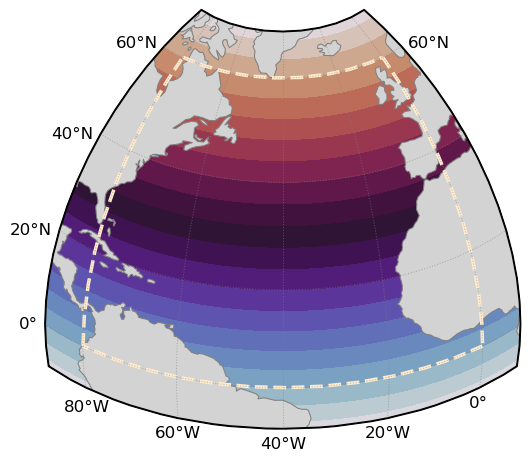

In [3]:
bbox          = [-90,10,-10,70] # Plotting Extent
plot_this_box = [-80,0,0,60]    # Locator box indicating a region
proj          = ccrs.PlateCarree() # Need to add this to most things as "transform=proj"

# Make random data to plot
lon = np.arange(-90,11,1)
lat = np.arange(-10,71,1)
xx,yy = np.meshgrid(lon,lat)

# Initialize figure
fig,ax,_ = init_orthomap(1,1,bbox)

# Add Coasts/Continent
ax = add_coast_grid(ax,bbox,fill_color='lightgray',line_color='gray')

# Plot contours
ax.contourf(lon,lat,yy,transform=proj,zorder=-1,levels=25,cmap='twilight')

# Plot box
plot_box(plot_this_box,ax=ax,proj=proj,linestyle='dashed',linewidth=2.5,color='blanchedalmond')